In [1]:
# load libraries and magics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
import scipy.stats as stats
import joblib
import pickle
%matplotlib inline
plt.style.use('bmh')

In [2]:
# Calculate the confidence interval
def confidence_interval(model, X, y, score):
    confidence = 0.95
    scores = cross_val_score(model, X, y, n_jobs=-1, cv=10, scoring=score)
    print(scores)
    print('95% CI: ', stats.t.interval(confidence, len(scores) - 1,
                 loc=scores.mean(),
                 scale=scores.std(ddof=1)/np.sqrt(len(scores))))

**2. Gross Income**

**Multiple linear regression without Lasso regularization**

In [4]:
# Load gross income question's files
with open('X_gi_test.pkl', 'rb') as file:
    X_gi_test = pickle.load(file)
with open('y_gi_test.pkl', 'rb') as file:
    y_gi_test = pickle.load(file)

reg_gi = joblib.load('reg_gi.pkl')
confidence_interval(reg_gi, X_gi_test, y_gi_test, 'r2')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
95% CI:  (nan, nan)


It can be seen from the 10 ratings that the model perfectly fits the test set. The 95% confidence interval cannot be displayed because all 10 cross-validations gave a score of 1, resulting in no interval generation. This gives us reason to suspect that a certain feature in the data set has a very large correlation with the target gross income.

**Multiple linear regression with Lasso regularization**

In [5]:
# Load gross income lasso model
lasso_gi = joblib.load('lasso_gi.pkl')
confidence_interval(lasso_gi, X_gi_test, y_gi_test, 'r2')

[0.99999997 0.99999994 0.99999996 0.99999997 0.99999997 0.99999996
 0.99999997 0.99999996 0.99999996 0.99999993]
95% CI:  (0.999999949476992, 0.9999999667352704)


The R-squares given by the lasso regression model in 10 cross-validations were extremely close to 1, causing its interval to be between two values very close to 1. This also means that the model predicts the test sets perfectly.

**3. Unit Price**

**Multiple linear regression without Lasso regularization**

In [6]:
# Load unit price question's files
with open('X_up_test.pkl', 'rb') as file:
    X_up_test = pickle.load(file)
with open('y_up_test.pkl', 'rb') as file:
    y_up_test = pickle.load(file)

reg_up = joblib.load('reg_up.pkl')
confidence_interval(reg_up, X_up_test, y_up_test, 'r2')

[0.83404801 0.70536005 0.78172399 0.82056849 0.90004884 0.79939464
 0.78633037 0.72680215 0.77148417 0.42938543]
95% CI:  (0.6647751923762993, 0.8462540338055066)


The R-square values given by 10 times of cross-validation were very different, which resulted in the 95% confidence interval is about 0.66-0.85. This indicates that the model can predict unit price well but is not good in reliability.

**Multiple linear regression with Lasso regularization**

In [7]:
# Load unit price lasso model
lasso_up = joblib.load('lasso_up.pkl')
confidence_interval(lasso_up, X_up_test, y_up_test, 'r2')

[0.80873545 0.66830498 0.76431738 0.8478596  0.88385352 0.86796953
 0.81243753 0.75003663 0.79932079 0.45208976]
95% CI:  (0.6748742709979244, 0.856110762528122)


The 95% confidence interval of this task is about 0.67-0.86, which is not much different from linear regression. Similar as the linear regression model without regularization, the model can predict unit price well but is stil not good in reliability.

**4. Gender**

**Logistic regression**

In [8]:
# Load gender question's files
with open('X_g_test.pkl', 'rb') as file:
    X_g_test = pickle.load(file)
with open('y_g_test.pkl', 'rb') as file:
    y_g_test = pickle.load(file)

log_g = joblib.load('log_g.pkl')

In [9]:
# Output attributes and their coefficients
poly_attributes_g = ['Intercept']
attrib_names = np.array(['Product line', 'Payment', 'gross income'])
N_attributes = log_g.named_steps['poly_feat'].powers_.shape[0]

for i in range(1,N_attributes):
    temp = attrib_names[log_g.named_steps['poly_feat'].powers_[i,:]==1]
    
    if len(temp)==1:
        poly_attributes_g += [temp[0]]
    else:
        poly_attributes_g += [temp[0]+' + '+temp[1]]
        
poly_attributes_g = np.array(poly_attributes_g).reshape(-1,1)
w_g = log_g.named_steps['classifier'].coef_.T
pd.DataFrame(np.hstack((poly_attributes_g, w_g)), columns=['Attributes', 'Coefficients'])

,Attributes,Coefficients
0,Intercept,1.4266592579426441e-05
1,Product line,-0.0008915636385800437
2,Payment,-0.00021086500102048575
3,gross income,-0.00033372780435629974
4,Product line + Payment,-0.0013488729249204958
5,Product line + gross income,-0.0025618382137598933
6,Payment + gross income,-0.0001326472941749086


Among the 7 attributes, 'Product line + gross income' has the highest coefficients, which also means that it is the most informative attribute.

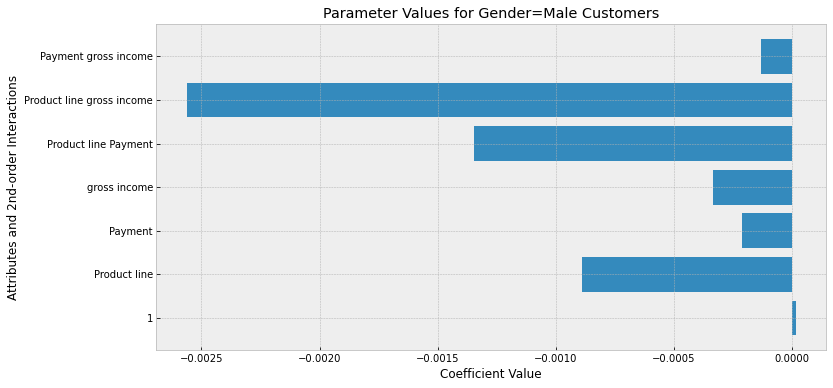

In [10]:
# Male customers parameters values for all attributes and 2nd-order interactions
with open('male.pkl', 'rb') as file:
    male = pickle.load(file)

X_male = male[['Product line', 'Payment', 'gross income']]

# Calculate the parameter values for the logistic regression model
parameter_values = log_g.named_steps['classifier'].coef_

# Create a DataFrame to store the attributes and their coefficients
attributes_and_coefficients = pd.DataFrame({
    'Attributes': log_g.named_steps['poly_feat'].get_feature_names_out(input_features=X_male.columns),
    'Coefficients': parameter_values[0]
})

# Plot
plt.figure(figsize=(12, 6))
plt.barh(attributes_and_coefficients['Attributes'], attributes_and_coefficients['Coefficients'])
plt.xlabel('Coefficient Value')
plt.ylabel('Attributes and 2nd-order Interactions')
plt.title('Parameter Values for Gender=Male Customers')
plt.show()

By observation, ‘Product line + gross income’ is also the most informative attribute in male customers.

In [11]:
confidence_interval(log_g, X_g_test, y_g_test, 'accuracy')

[0.57142857 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857
 0.5        0.5        0.5        0.5       ]
95% CI:  (0.5164708058728689, 0.569243479841417)


This means that the model will tend to predict more male customers when predicting customer gender.

**5. Customer type**

**Logistic Regression**

In [12]:
# Load customer type question's files
with open('X_ct_test.pkl', 'rb') as file:
    X_ct_test = pickle.load(file)
with open('y_ct_test.pkl', 'rb') as file:
    y_ct_test = pickle.load(file)

log_ct = joblib.load('log_ct.pkl')

In [13]:
# Output attributes and their coefficients
poly_attributes_ct = ['Intercept']
attrib_names = np.array(['Gender', 'Date', 'Time'])
N_attributes = log_ct.named_steps['poly_feat'].powers_.shape[0]

for i in range(1,N_attributes):
    temp = attrib_names[log_g.named_steps['poly_feat'].powers_[i,:]==1]
    
    if len(temp)==1:
        poly_attributes_ct += [temp[0]]
    else:
        poly_attributes_ct += [temp[0]+' + '+temp[1]]
        
poly_attributes_ct = np.array(poly_attributes_ct).reshape(-1,1)
w_ct = log_ct.named_steps['classifier'].coef_.T
pd.DataFrame(np.hstack((poly_attributes_ct, w_ct)), columns=['Attributes', 'Coefficients'])

,Attributes,Coefficients
0,Intercept,8.990082754278079e-05
1,Gender,0.00031465289639973277
2,Date,0.0005843553790280751
3,Time,-0.00022475206885695198
4,Gender + Date,0.0008540578616564175
5,Gender + Time,0.0004944545514852944
6,Date + Time,0.0006293057927994655


‘Gender + Date’ is the most informative.

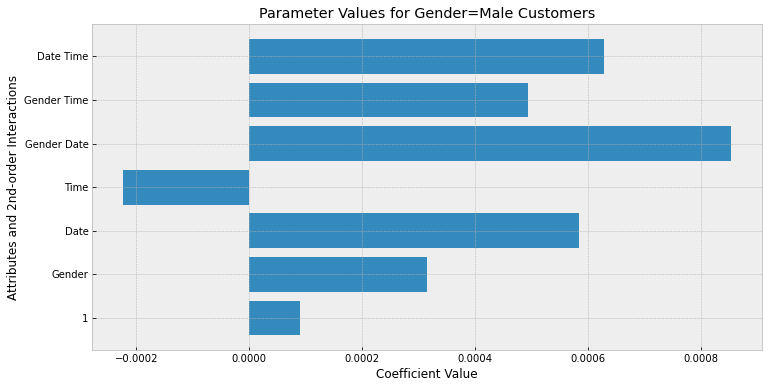

In [14]:
# Normal customers parameters values for all attributes and 2nd-order interactions
with open('normal.pkl', 'rb') as file:
    normal = pickle.load(file)

# Extract the relevant features (Product line, Payment, and gross income)
X_normal = normal[['Gender', 'Date', 'Time']]

# Calculate the parameter values for the logistic regression model
parameter_values = log_ct.named_steps['classifier'].coef_

# Create a DataFrame to store the attributes and their coefficients
attributes_and_coefficients = pd.DataFrame({
    'Attributes': log_g.named_steps['poly_feat'].get_feature_names_out(input_features=X_normal.columns),
    'Coefficients': parameter_values[0]
})

# Plot
plt.figure(figsize=(12, 6))
plt.barh(attributes_and_coefficients['Attributes'], attributes_and_coefficients['Coefficients'])
plt.xlabel('Coefficient Value')
plt.ylabel('Attributes and 2nd-order Interactions')
plt.title('Parameter Values for Gender=Male Customers')
plt.show()

‘Gender + Date’ is still the most informative in normal customers.

In [15]:
confidence_interval(log_ct, X_ct_test, y_ct_test, 'accuracy')

[0.57142857 0.57142857 0.57142857 0.57142857 0.57142857 0.57142857
 0.5        0.66666667 0.66666667 0.66666667]
95% CI:  (0.5531556663505299, 0.6325586193637558)


This means that the model will tend to predict more normal members when predicting customer type.

**6.** 

**Logistic regression**

In [16]:
# Load day of purchase question's files
with open('X_dp_test.pkl', 'rb') as file:
    X_dp_test = pickle.load(file)
with open('y_dp_test.pkl', 'rb') as file:
    y_dp_test = pickle.load(file)

log_dp = joblib.load('log_dp.pkl')
confidence_interval(log_dp, X_dp_test, y_dp_test, 'accuracy')

[0.15 0.1  0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15]
95% CI:  (0.133689214186295, 0.15631078581370492)


**Random forest**

In [18]:
# # Load day of purchase question's files
rf_dp = joblib.load('rf_dp.pkl')
confidence_interval(rf_dp, X_dp_test, y_dp_test, 'accuracy')

[0.1  0.15 0.05 0.3  0.15 0.1  0.2  0.15 0.15 0.2 ]
95% CI:  (0.10598659480727848, 0.20401340519272146)


By outputting the 95% confidence interval of both the logistic regression model and the random forest model, we find that the interval of the logistic regression model is approximately 0.13-0.16, while the interval of the random forest model is approximately 0.11-0.20. Since the interval of the logistic regression model has a smaller gap, this means that it can predict the day of purchase more reliably, which also means that we will give priority to the logistic regression model.